In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import Input,Embedding, Dropout,Bidirectional, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# UTILITY FUNCTIONS FOR PREPROCESSING AND OTHER TASKS

In [5]:
def preprocess_tweet(text):
    #Convert to lowercasetext = text.lower();
    text=text.lower();
    #Regex to remove unecessary charcters
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text).strip()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the processed tokens back into a text string
    processed_text = ' '.join(tokens)
    return processed_text


In [6]:
def displayMetrics(true_labels, predicted_labels):
    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Accuracy Score
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)
    
    # Precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)
    
    # Recall
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    print("Recall:", recall)
    
    # F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print("F1 Score:", f1)

In [57]:
def reduce_sentiments(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

# Loading Data


In [38]:
train_df=pd.read_csv("Corona_NLP_train.csv", encoding='latin1')

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [39]:
test_df=pd.read_csv("Corona_NLP_test.csv", encoding='latin1')

test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [40]:
print("Information about Training Data\n")
train_df.info()

print("Information about Testing Data\n")
test_df.info()

Information about Training Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
Information about Testing Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 n

In [52]:
print("Training Shape: ", train_df.shape)
print("Testing Shape: ", test_df.shape)

Training Shape:  (41157, 6)
Testing Shape:  (3798, 6)


In [53]:
df = pd.concat([train_df, test_df])
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

# Pre-Processing Data

In [54]:
test_df.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [41]:
#missing values in lOCATION replaced with string 'Unknown'
test_df['Location'].fillna('Unknown', inplace=True)

train_df['Location'].fillna('Unknown', inplace=True)

print(test_df.isnull().sum())

print(train_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


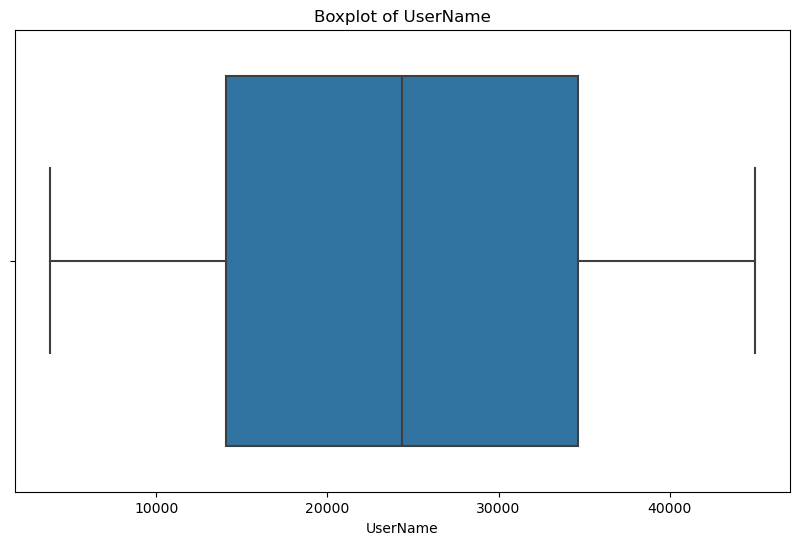

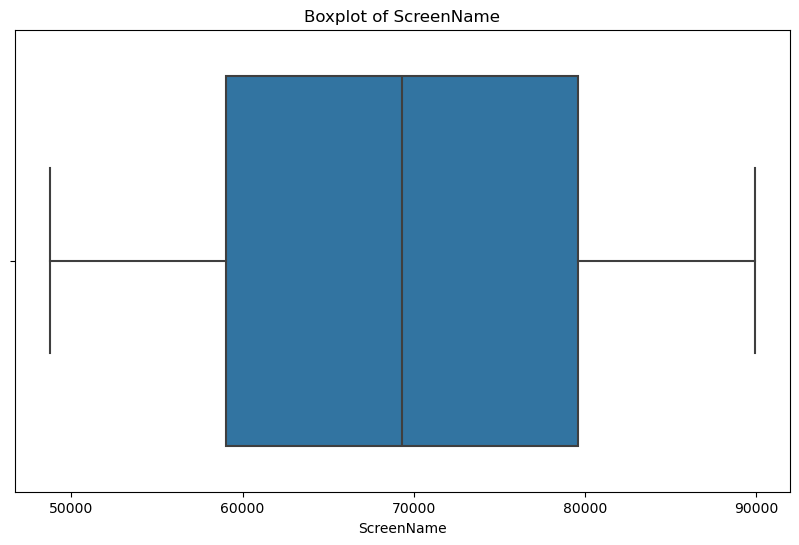

In [56]:
numerical = list(train_df.select_dtypes(include=['int64', 'float64']).columns)

# Boxplot for each variable in numerical list

for col in numerical:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

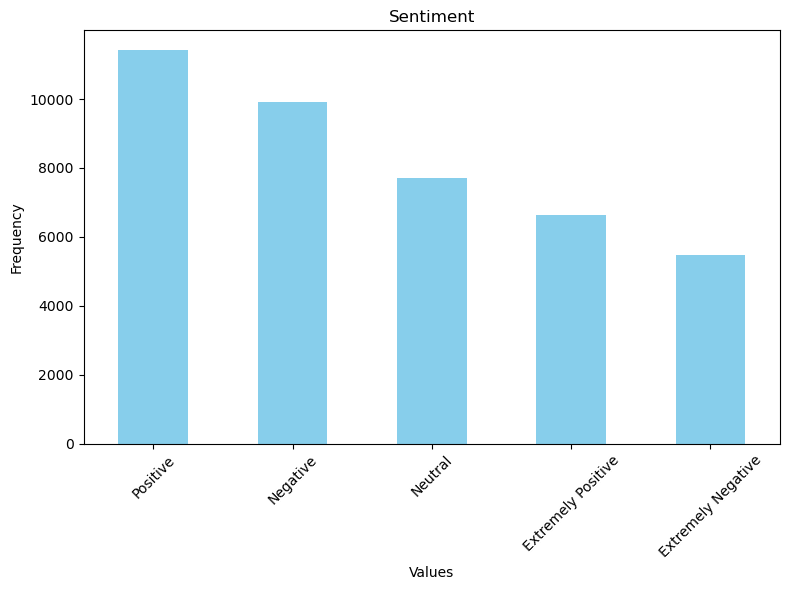

In [14]:
value_counts = train_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:

#drop unecessary columns
columns_to_drop = ['UserName', 'ScreenName', 'Location', 'TweetAt']

for col in columns_to_drop:
    if col in train_df.columns:
        train_df.drop(columns=[col], inplace=True)
    if col in test_df.columns:
        test_df.drop(columns=[col], inplace=True)

label_encoder = LabelEncoder()
train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['Sentiment'])
#uses same encoding patterns as before
test_df['sentiment_encoded'] = label_encoder.transform(test_df['Sentiment'])



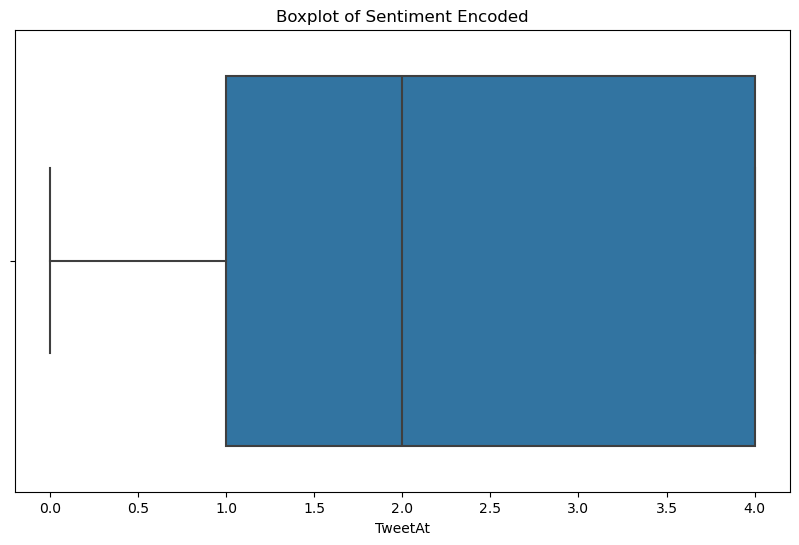

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['sentiment_encoded'])
plt.title('Boxplot of Sentiment Encoded')
plt.xlabel(col)
plt.show()

In [43]:
#Applying Preprocessing Steps to our target column

train_df["Final_Tweet"]=train_df['OriginalTweet'].apply(preprocess_tweet)

test_df["Final_Tweet"]=test_df['OriginalTweet'].apply(preprocess_tweet)

In [44]:
train_df.head()

,OriginalTweet,Sentiment,sentiment_encoded,Final_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,3,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,4,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,4,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,Positive,4,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,ready go supermarket covid outbreak im paranoi...


In [45]:
test_df.head()

,OriginalTweet,Sentiment,sentiment_encoded,Final_Tweet
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,0,trending new yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,Positive,4,couldnt find hand sanitizer fred meyer turned ...
2,Find out how you can protect yourself and love...,Extremely Positive,1,find protect loved one coronavirus
3,#Panic buying hits #NewYork City as anxious sh...,Negative,2,panic buying hit newyork city anxious shopper ...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,3,toiletpaper dunnypaper coronavirus coronavirus...


In [46]:
#After Preprocessing we dont need Original_Tweet Column so we drop it
if 'OriginalTweet' in train_df.columns:
 train_df.drop(columns=['OriginalTweet'], axis=1, inplace=True)
if 'OriginalTweet' in test_df.columns:
 test_df.drop(columns=['OriginalTweet'], axis=1, inplace=True)

## Apllying Padding

In [47]:
#tokeniser splits our tweets into individual words/subwords
#this step builds vocabulary of the tokenizer
#num_words will control the maximum size of vocabulary
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Final_Tweet'])

#this step encodes each word of each tweet into an integer sequence
X_train = tokenizer.texts_to_sequences(train_df['Final_Tweet'])
X_test = tokenizer.texts_to_sequences(test_df['Final_Tweet'])

In [48]:
vocab_size = len(tokenizer.word_index)

#All tweet lengths
tweet_lengths = [len(tweet) for tweet in train_df['Final_Tweet']]
max_length = max(set(tweet_lengths), key=tweet_lengths.count) + 10

#padding seqeunce for both training and test data
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')

X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

y_train = train_df['Sentiment']
y_test = test_df['Sentiment']
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(vocab_size, max_length)

53477 180


## Model Architecture

In [23]:
#Set maxlen based on the length of your input sequences
maxlen = max(len(seq) for seq in X_train)
#we have 5 classes of Sentiment
num_classes = len(label_encoder.classes_)

In [24]:
#+1 for the padding token
#output_dim represents the dimensionality of the word vectors (holding semantic meaning) to be used by model
#In Dense layer units=num_classes since it is meant to classify sentiments under 5 classes
# Used softmax because its an multi-classification problem
model = Sequential()
model.add(Embedding(input_dim=(vocab_size), output_dim=128))
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(units=num_classes, activation='softmax'))

In [25]:
#Using sparse_categorical_crossentropy since we have encoded data in form of integers
#Using accuracy as metric since its an classification task
#optimizer determines how the model's weights are updated based on the loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

USING CALLBACK TO OPTIMIZE MODEL TRAINING PROCESS


In [26]:
#prevent overfitting by stopping the training process early
# number of epochs to wait before stopping the training process if no improvement is observed
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [67]:
#history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=20, batch_size=64, callbacks=[early_stopping])

# Save the model
# model.save("early.keras")

from keras.models import load_model
model = load_model('early.keras')

In [28]:
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=2)

In [ ]:
# Train the model with the ModelCheckpoint callback
model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=20, batch_size=256, callbacks=[model_checkpoint])

In [70]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Print the model summary
print(model.summary())

119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7093 - loss: 0.8153
Test Loss: 0.8087465763092041
Test Accuracy: 0.7074776291847229


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 180, 128)            │       6,845,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,328,529 (81.36 MB)

 Trainable params: 7,109,509 (27.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,219,020 (54.24 MB)

None


In [71]:
# tweets = test_df['Final_Tweet'][:20]

tweets = test_df['Final_Tweet']
data_sequences = tokenizer.texts_to_sequences(tweets)
data_padded = pad_sequences(data_sequences, maxlen=max_length, padding='post', truncating='post')
predictions = model.predict(data_padded)

predicted_labels = np.argmax(predictions, axis=1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step


In [72]:
# Assuming you have a mapping dictionary from integer labels to class names
label_mapping = {0: 'Extremely Negative', 1: 'Extremely Positive', 2: 'Negative', 3: 'Neutral', 4: 'Positive'}

# Map integer predictions to class names
predicted_class_names = [label_mapping[label] for label in predicted_labels]

# Now 'predicted_class_names' contains the predicted class names for your input data

In [73]:
for i in range(len(predicted_class_names)):
    print('Tweet: ', test_df['Final_Tweet'][i])
    print('Predicted Class: ', predicted_class_names[i])
    print('Actual Class: ', test_df['Sentiment'][i], '\n')

Tweet:  trending new yorkers encounter empty supermarket shelf pictured wegmans brooklyn soldout online grocer foodkick maxdelivery coronavirusfearing shopper stock
Predicted Class:  Negative
Actual Class:  Extremely Negative 

Tweet:  couldnt find hand sanitizer fred meyer turned amazon pack purellcheck coronavirus concern driving price
Predicted Class:  Positive
Actual Class:  Positive 

Tweet:  find protect loved one coronavirus
Predicted Class:  Extremely Positive
Actual Class:  Extremely Positive 

Tweet:  panic buying hit newyork city anxious shopper stock foodampmedical supply healthcare worker becomes bigapple st confirmed coronavirus patient bloomberg staged event qanon qanon qanon election cdc
Predicted Class:  Extremely Negative
Actual Class:  Negative 

Tweet:  toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid news corvid newsmelb dunnypapergate costco one week everyone buying baby milk powder next everyone buying toilet paper
Predicted Class: 

In [74]:
displayMetrics(y_test_encoded, predicted_labels)

Confusion Matrix:
[[427   0 143   7  15]
 [  5 480  26   1  87]
 [157  18 680  43 143]
 [  6   8 104 430  71]
 [ 17 126 115  19 670]]
Accuracy: 0.7074776197998947
Precision: 0.7126462440916294
Recall: 0.7074776197998947
F1 Score: 0.7084108274681782


# Model 2

In [58]:
from keras.models import load_model
model2 = load_model('early2.keras')

In [59]:
loss, accuracy = model2.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Print the model summary
print(model2.summary())

119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.6500 - loss: 1.0071
Test Loss: 1.020555853843689
Test Accuracy: 0.6484991908073425


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 180, 128)            │       6,846,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 180, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,848,849 (83.35 MB)

 Trainable params: 7,282,949 (27.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,565,900 (55.56 MB)

None


In [60]:
predictions2 = model2.predict(data_padded)

predicted_labels2 = np.argmax(predictions2, axis=1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step


In [62]:
displayMetrics(y_test_encoded, predicted_labels2)

Confusion Matrix:
[[361   1 183  15  32]
 [  3 399  28   3 166]
 [131  19 633  72 186]
 [  8   2 103 405 101]
 [ 17 108 124  33 665]]
Accuracy: 0.6484992101105845
Precision: 0.6583637267926634
Recall: 0.6484992101105845
F1 Score: 0.6503158534693398


## Using 3 Classes instead of 5

In [21]:
train_df.drop(columns=["sentiment_encoded"], inplace=True)
test_df.drop(columns=["sentiment_encoded"], inplace=True)

train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: reduce_sentiments(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: reduce_sentiments(x))

label_encoder = LabelEncoder()
train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['Sentiment'])
#uses same encoding patterns as before
test_df['sentiment_encoded'] = label_encoder.transform(test_df['Sentiment'])

y_train = train_df['Sentiment']
y_test = test_df['Sentiment']
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [22]:
train_df.head()

,Sentiment,Final_Tweet,sentiment_encoded
0,netural,menyrbie philgahan chrisitv,1
1,positive,advice talk neighbour family exchange phone nu...,2
2,positive,coronavirus australia woolworth give elderly d...,2
3,positive,food stock one empty please dont panic enough ...,2
4,negative,ready go supermarket covid outbreak im paranoi...,0


In [29]:
model3 = Sequential()
model3.add(Embedding(input_dim=(vocab_size), output_dim=128))
model3.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
model3.add(Dense(units=3, activation='softmax'))

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = "checkpoint_3_classes.keras"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

In [30]:
#from keras.models import load_model
#model = load_model('checkpoint_3_classes.keras')

history = model3.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=10, batch_size=64, callbacks=[model_checkpoint])

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 295s 445ms/step - accuracy: 0.6289 - loss: 0.7968 - val_accuracy: 0.8057 - val_loss: 0.5186
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 355s 551ms/step - accuracy: 0.8713 - loss: 0.3820 - val_accuracy: 0.8278 - val_loss: 0.4931
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 383s 596ms/step - accuracy: 0.9001 - loss: 0.3111 - val_accuracy: 0.8323 - val_loss: 0.4824
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 336s 522ms/step - accuracy: 0.9108 - loss: 0.2733 - val_accuracy: 0.8331 - val_loss: 0.5004
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 298s 463ms/step - accuracy: 0.9228 - loss: 0.2301 - val_accuracy: 0.8307 - val_loss: 0.5459
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 301s 467ms/step - accuracy: 0.9347 - loss: 0.1946 - val_accuracy: 0.8186 - val_loss: 0.5776
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 300s 466ms/step - accuracy: 0.9460 - loss: 0.1620 - val_accuracy: 0.8049 - val_loss: 0.6614
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 300s 466ms/step - accuracy: 0.9554 -

In [19]:
from keras.models import load_model
model3 = load_model('checkpoint_3_classes.keras')

In [31]:
loss, accuracy = model3.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Print the model summary
print(model3.summary())

119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.7919 - loss: 0.9265
Test Loss: 0.9103551506996155
Test Accuracy: 0.8001579642295837


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 180, 128)            │       6,845,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,326,987 (81.36 MB)

 Trainable params: 7,108,995 (27.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,217,992 (54.24 MB)

None


In [32]:
# tweets = test_df['Final_Tweet'][:20]

tweets = test_df['Final_Tweet']
data_sequences = tokenizer.texts_to_sequences(tweets)
data_padded = pad_sequences(data_sequences, maxlen=max_length, padding='post', truncating='post')

predictions3 = model3.predict(data_padded)

predicted_labels_3 = np.argmax(predictions3, axis=1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step


In [33]:
# Assuming you have a mapping dictionary from integer labels to class names
label_mapping_3 = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Map integer predictions to class names
predicted_class_names_3 = [label_mapping_3[label] for label in predicted_labels_3]

# Now 'predicted_class_names' contains the predicted class names for your input data

In [34]:
for i in range(len(predicted_class_names_3)):
    print('Tweet: ', test_df['Final_Tweet'][i])
    print('Predicted Class: ', predicted_class_names_3[i])
    print('Actual Class: ', test_df['Sentiment'][i], '\n')

Tweet:  trending new yorkers encounter empty supermarket shelf pictured wegmans brooklyn soldout online grocer foodkick maxdelivery coronavirusfearing shopper stock
Predicted Class:  Negative
Actual Class:  negative 

Tweet:  couldnt find hand sanitizer fred meyer turned amazon pack purellcheck coronavirus concern driving price
Predicted Class:  Positive
Actual Class:  positive 

Tweet:  find protect loved one coronavirus
Predicted Class:  Positive
Actual Class:  positive 

Tweet:  panic buying hit newyork city anxious shopper stock foodampmedical supply healthcare worker becomes bigapple st confirmed coronavirus patient bloomberg staged event qanon qanon qanon election cdc
Predicted Class:  Negative
Actual Class:  negative 

Tweet:  toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid news corvid newsmelb dunnypapergate costco one week everyone buying baby milk powder next everyone buying toilet paper
Predicted Class:  Neutral
Actual Class:  netural 

Tweet:

In [36]:
displayMetrics(y_test_encoded, predicted_labels_3)

Confusion Matrix:
[[1324   84  225]
 [ 114  421   84]
 [ 199   53 1294]]
Accuracy: 0.8001579778830964
Precision: 0.7993090138410331
Recall: 0.8001579778830964
F1 Score: 0.7993093169314617
